# Crop Type Classification Model – Project Overview

This notebook presents the **training workflow for the Crop Type Classification model**, 
developed to predict which crop (e.g., *Maize, Soy, Sunflower, Wheat, Pasture, etc.*) 
is growing in each field using satellite and environmental data.

The model uses a combination of:
- **Sentinel-1 radar features** (e.g., VH/VV backscatter, polarization ratios)
- **Sentinel-2 vegetation indices** (e.g., NDVI, EVI, LAI)
- **Environmental and management variables** (e.g., irrigation, week of year, rainfall)

We apply a modern **machine learning pipeline** based on **XGBoost** — a powerful 
tree-based algorithm — and use **feature selection** techniques to find the 
variables that best explain crop type differences.

---

## 🎯 Objectives
1. Combine multiple satellite datasets into a harmonized, high-quality table of field observations.  
2. Train a robust **XGBoost classifier** for crop type prediction.  
3. Apply **Forward Feature Selection (FFS)** to automatically identify the most relevant variables.  
4. Validate model performance with **grouped cross-validation** and **independent test years**.  
5. Save the final trained model and the selected feature list for future predictions.

---

## 🧭 Workflow Summary

| Step | Description |
|------|--------------|
| **0.1** | Import required libraries |
| **0.2** | Set up parameters and file paths |
| **0.3** | Load, clean, and merge datasets |
| **0.4** | Train initial XGBoost model to estimate feature importance |
| **0.5** | Select top features and retrain |
| **0.6** | Apply Forward Feature Selection (FFS) with grouped cross-validation |
| **0.7** | Plot cumulative accuracy improvement |
| **0.8** | Train the final model using the best features |
| **0.9** | Visualize feature importance |
| **0.10** | Evaluate performance and display confusion matrix |
| **0.11** | Save model, features, and evaluation results |

---

## 📦 Outputs Produced
- Trained **XGBoost model file** (`.joblib`)  
- **Feature list** in `.json` format  
- **Confusion matrix images** and `.csv` files  
- **Evaluation summaries** with accuracy, F1-score, and per-class performance  


## 0.1 Importing Required Libraries

In this section, we import all the Python packages needed for data handling, 
machine learning, and visualization.

- **pandas**, **numpy** – for data cleaning and manipulation  
- **xgboost**, **scikit-learn**, **mlxtend** – for model training and feature selection  
- **matplotlib**, **seaborn** – for plots and charts  
- **joblib**, **os**, **time** – for saving results and measuring execution time  

These imports set up the tools used throughout the workflow.


In [1]:
import json
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import dump, Parallel, delayed
from xgboost import XGBClassifier  # XGBoost classifier
from sklearn.metrics import (
    ConfusionMatrixDisplay, 
    precision_score, 
    recall_score, 
    confusion_matrix, 
    accuracy_score
)
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import train_test_split
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import seaborn as sns
import warnings  # Import the warnings module
from matplotlib import cm

## 0.2 Setup and Define Model Parameters

Here we define key parameters that control how the model runs:

- **Input datasets and folders** – paths where data is read and results are saved  
- **Model hyperparameters** – number of trees, learning rate, tree depth, etc.  
- **Feature selection settings** – how many features to test and when to stop  
- **Parallel processing** – defines how many CPU cores are used  

This step makes the notebook easy to reproduce and modify.

In [2]:
# INPUT DATA
dataset_name = 'SB25rAll'
reduction_method = '_n0.2_process_filt'

dataset_name1 = 'All'
reduction_method1 = '_n0.2_rebalanced_filt'

dataset_name2 = 'SB25r'
reduction_method2 = '_n0.2_process_filt'

# INPUT PARAMETERS
dataset_fraction = 1
top_N = 25  # You can tune this number to 25, 20, etc.
ffs_features = 25
Early_stopping_threshold = 0.0001 # Early stopping threshold FFS 
# Secondary Parameters
columns_selected = 4
# CPUs
ncpus = max(2, os.cpu_count() // 2)  # Safer for M1 + 8GB RAM
# Hyperparameters for XGBoost
n_estimators = 200
learning_rate = 0.1
max_depth = 6
subsample = 0.8
colsample_bytree = 0.8
r_s = 1

# File Paths
base_path = 'Data_Preparation/InputModel'
model_basepath = 'Models'
model_pic_basepath = 'Models_Pictures'

# Create folders if necessary
for path in [model_basepath]:
    if not os.path.exists(path):
        os.makedirs(path)

## 0.3 Loading and Preprocessing the Dataset

We now load and merge the datasets used for training:

1. Read the `All` and `SB25r` datasets.  
2. Identify and keep only the **common columns** shared by both.  
3. Merge them into a single combined dataframe.  
4. Reorder columns to have identifiers (`FIELDID`, `Crop_type`, `Crop_num`, `Year`) first.  

Next, we check the distribution of samples across crop types and years to ensure 
the dataset is balanced and representative.  
We also visualize **weekly NDVI averages** to understand how vegetation evolves for each crop type.

In [3]:
# Start total timing
total_start_time = time.time()

In [4]:
# Load dataset
output_file1 = os.path.join(base_path, f'{dataset_name1}{reduction_method1}.csv')
df1 = pd.read_csv(output_file1)
df1 = df1.sample(frac=dataset_fraction, random_state=1)
# print df1 columns
print("Columns in df1:", df1.columns.tolist())

output_file2 = os.path.join(base_path, f'{dataset_name2}{reduction_method2}.csv')
df2 = pd.read_csv(output_file2)
df2 = df2.sample(frac=dataset_fraction, random_state=1)
# print df2 columns
print("Columns in df2:", df2.columns.tolist())

Columns in df1: ['FIELDID', 'Crop_type', 'Crop_num', 'Year', 'week', 'veg_mean_evi', 'veg_mean_lai', 'veg_mean_pvr', 'veg_mean_msi', 'veg_mean_ndvi', 'veg_median_evi', 'veg_median_lai', 'veg_median_pvr', 'veg_median_msi', 'veg_median_ndvi', 'veg_max_evi', 'veg_max_lai', 'veg_max_pvr', 'veg_max_msi', 'veg_max_ndvi', 'veg_min_evi', 'veg_min_lai', 'veg_min_pvr', 'veg_min_msi', 'veg_min_ndvi', 'veg_std_evi', 'veg_std_lai', 'veg_std_pvr', 'veg_std_msi', 'veg_std_ndvi', 's1_vh', 's1_vv', 's1_angle', 's1_sigma_vh_linear', 's1_sigma_vv_linear', 's1_p_ratio', 's1_rvi', 's1_rcspr', 'Irrigation', 'week_sin', 'week_cos', 'growth_rate_ndvi', 'growth_rate_evi', 'growth_rate_lai', 'mean_combined_vegetation_index', 'ndvi_evi_ratio']
Columns in df2: ['FIELDID', 'Crop_type', 'Crop_num', 'area_ha', 'Year', 'week', 'chirps_mean_prec', 'chirps_sum_prec', 'chirps_max_prec', 'chirps_min_prec', 'chirps_std_prec', 'chirps_cnt_prec', 'era5_temp2m', 'era5_temp2mmin', 'era5_temp2max', 'era5_totprec', 'era5_rh', '

In [5]:
# Find the common columns
common_cols = list(set(df1.columns) & set(df2.columns))
print("Common columns:", common_cols)

# Keep only the common columns in both DataFrames
df1_common = df1[common_cols]
df2_common = df2[common_cols]

# Merge (example: concatenate rows)
df = pd.concat([df1_common, df2_common], ignore_index=True)

print("Final merged df shape:", df.shape)




Common columns: ['veg_max_ndvi', 'growth_rate_lai', 'veg_median_evi', 'veg_max_msi', 'veg_std_ndvi', 's1_angle', 'veg_min_ndvi', 'veg_mean_msi', 'veg_min_lai', 's1_vh', 's1_sigma_vv_linear', 's1_rcspr', 's1_sigma_vh_linear', 'veg_median_ndvi', 'veg_mean_evi', 'veg_std_evi', 'veg_min_msi', 'week_cos', 'veg_min_evi', 'veg_std_pvr', 's1_p_ratio', 's1_vv', 'veg_median_msi', 'veg_std_lai', 'week', 'veg_max_pvr', 'week_sin', 's1_rvi', 'veg_std_msi', 'veg_median_lai', 'Year', 'Crop_type', 'mean_combined_vegetation_index', 'veg_mean_ndvi', 'veg_max_lai', 'Irrigation', 'growth_rate_evi', 'veg_mean_pvr', 'ndvi_evi_ratio', 'FIELDID', 'veg_median_pvr', 'veg_min_pvr', 'Crop_num', 'veg_mean_lai', 'veg_max_evi', 'growth_rate_ndvi']


Final merged df shape: (127379, 46)


In [6]:
# Desired first columns
first_cols = ['FIELDID', 'Crop_type', 'Crop_num', 'Year']

# Ensure the order for the rest of the columns
other_cols = [col for col in df.columns if col not in first_cols]

# Reorder DataFrame
df = df[first_cols + other_cols]

# print column names
print(df.columns)
print(f"Data shape: {df.shape}")

# Save the merged DataFrame
output_file = os.path.join(base_path, f'{dataset_name}{reduction_method}.csv')
df.to_csv(output_file, index=False)


Index(['FIELDID', 'Crop_type', 'Crop_num', 'Year', 'veg_max_ndvi',
       'growth_rate_lai', 'veg_median_evi', 'veg_max_msi', 'veg_std_ndvi',
       's1_angle', 'veg_min_ndvi', 'veg_mean_msi', 'veg_min_lai', 's1_vh',
       's1_sigma_vv_linear', 's1_rcspr', 's1_sigma_vh_linear',
       'veg_median_ndvi', 'veg_mean_evi', 'veg_std_evi', 'veg_min_msi',
       'week_cos', 'veg_min_evi', 'veg_std_pvr', 's1_p_ratio', 's1_vv',
       'veg_median_msi', 'veg_std_lai', 'week', 'veg_max_pvr', 'week_sin',
       's1_rvi', 'veg_std_msi', 'veg_median_lai',
       'mean_combined_vegetation_index', 'veg_mean_ndvi', 'veg_max_lai',
       'Irrigation', 'growth_rate_evi', 'veg_mean_pvr', 'ndvi_evi_ratio',
       'veg_median_pvr', 'veg_min_pvr', 'veg_mean_lai', 'veg_max_evi',
       'growth_rate_ndvi'],
      dtype='object')
Data shape: (127379, 46)


In [7]:
# print unique values in 'Crop_type' and their counts
print(df['Crop_type'].value_counts())
# print the number of unique fields per crop type
print(df.groupby('Crop_type')['FIELDID'].nunique())

Crop_type
Pasture       32824
Maize         24925
Tree          19733
Soy           19078
Lucern         9623
Sunflower      9116
Wheat          8688
Fallow         2759
Groundnuts      321
Sorghum         312
Name: count, dtype: int64
Crop_type
Fallow          97
Groundnuts      11
Lucern         220
Maize         1147
Pasture        972
Sorghum         10
Soy           1519
Sunflower      783
Tree           333
Wheat           53
Name: FIELDID, dtype: int64


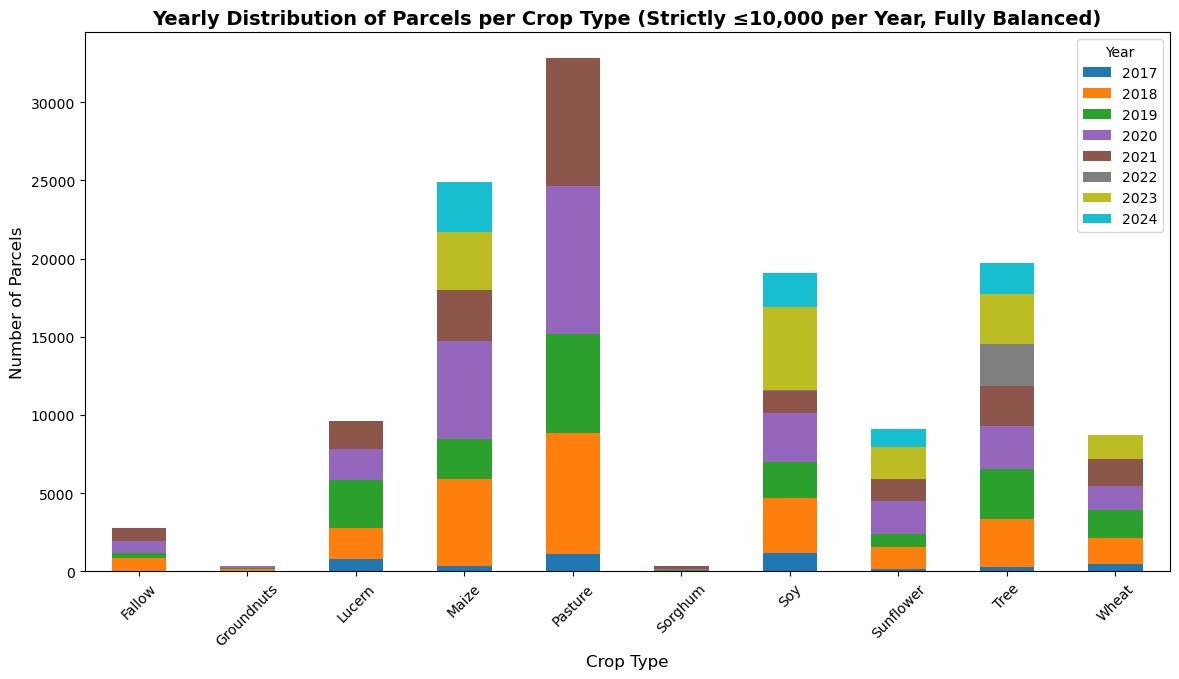

In [8]:
# Verify new unique FIELDID counts per crop and year
crop_year_counts_balanced = df.groupby(["Crop_type", "Year"]).size().unstack()


# Plot the balanced distribution
fig, ax = plt.subplots(figsize=(14, 7))

crop_year_counts_balanced.plot(kind="bar", stacked=True, cmap=cm.get_cmap("tab10"), ax=ax)

ax.set_title("Yearly Distribution of Parcels per Crop Type (Strictly ≤10,000 per Year, Fully Balanced)", fontsize=14, fontweight="bold")
ax.set_xlabel("Crop Type", fontsize=12)
ax.set_ylabel("Number of Parcels", fontsize=12)
# ax.set_ylim(0, 12050)  # ➤ Add y-axis limit here

ax.legend(title="Year")

plt.xticks(rotation=45)
plt.show()


# # # extract only Wheat from df and save as csv file
# df_wheat = df[df['Crop_type'] == 'Wheat']
# output_file = os.path.join(base_path, f'df_Wheat.csv')
# df_wheat.to_csv(output_file, index=False)

In [9]:
# Map numerical labels to crop names
crop_name_mapping = dict(zip(df['Crop_num'].unique(), df['Crop_type'].unique()))

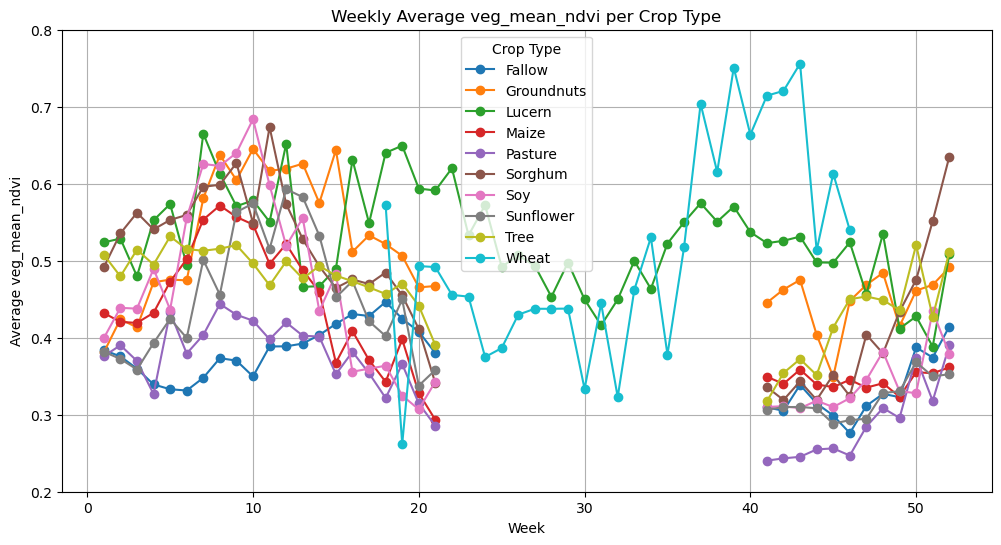

In [10]:
# Ensure 'week' and 'veg_mean_ndvi' are numeric
df.loc[:, "week"] = pd.to_numeric(df["week"], errors="coerce")
df.loc[:, "veg_mean_ndvi"] = pd.to_numeric(df["veg_mean_ndvi"], errors="coerce")


# Compute average veg_mean_ndvi per crop type per week
avg_ndvi_per_crop = df.groupby(["Crop_type", "week"], as_index=False)["veg_mean_ndvi"].mean()

# Create the plot
plt.figure(figsize=(12, 6))

# Plot each crop type's average NDVI time series
gap_threshold = 2  # max allowed week gap to keep the line

for crop in avg_ndvi_per_crop["Crop_type"].unique():
    subset = avg_ndvi_per_crop[avg_ndvi_per_crop["Crop_type"] == crop].sort_values("week")
    weeks = subset["week"].values
    ndvi_values = subset["veg_mean_ndvi"].values

    # Insert NaN where the gap is larger than threshold
    new_weeks = []
    new_ndvi = []
    for i in range(len(weeks)):
        new_weeks.append(weeks[i])
        new_ndvi.append(ndvi_values[i])
        if i < len(weeks) - 1 and (weeks[i+1] - weeks[i]) > gap_threshold:
            new_weeks.append(np.nan)
            new_ndvi.append(np.nan)

    plt.plot(new_weeks, new_ndvi, marker="o", linestyle="-", label=crop)

# Customize the plot
plt.xlabel("Week")
plt.ylabel("Average veg_mean_ndvi")
plt.title("Weekly Average veg_mean_ndvi per Crop Type")
plt.legend(title="Crop Type")
plt.grid(True)
plt.ylim(0.2, 0.8)

# Show the plot
plt.show()

In [11]:
# Define predictors and labels
predictors = df.columns[columns_selected:]
# print the predictors
print(f"Predictors: {predictors}")
label_col = 'Crop_num'

Predictors: Index(['veg_max_ndvi', 'growth_rate_lai', 'veg_median_evi', 'veg_max_msi',
       'veg_std_ndvi', 's1_angle', 'veg_min_ndvi', 'veg_mean_msi',
       'veg_min_lai', 's1_vh', 's1_sigma_vv_linear', 's1_rcspr',
       's1_sigma_vh_linear', 'veg_median_ndvi', 'veg_mean_evi', 'veg_std_evi',
       'veg_min_msi', 'week_cos', 'veg_min_evi', 'veg_std_pvr', 's1_p_ratio',
       's1_vv', 'veg_median_msi', 'veg_std_lai', 'week', 'veg_max_pvr',
       'week_sin', 's1_rvi', 'veg_std_msi', 'veg_median_lai',
       'mean_combined_vegetation_index', 'veg_mean_ndvi', 'veg_max_lai',
       'Irrigation', 'growth_rate_evi', 'veg_mean_pvr', 'ndvi_evi_ratio',
       'veg_median_pvr', 'veg_min_pvr', 'veg_mean_lai', 'veg_max_evi',
       'growth_rate_ndvi'],
      dtype='object')


In [12]:
# Drop rows with NaNs or infinite values in selected predictors or label
df_clean = df[[label_col] + list(predictors)].replace([np.inf, -np.inf], np.nan).dropna()

# Reassign cleaned data
X = df_clean[predictors].values
y = df_clean[label_col].values.ravel()


## 0.4 Train the Initial XGBoost Model

We train an initial **XGBoost** model using all available features.

The purpose of this first model is to estimate **feature importance**—which variables 
contribute the most to distinguishing between crop types.  
We also apply **sample weighting** to give smaller crop classes (like Sorghum or Groundnuts) 
the same importance as larger ones (like Pasture or Maize).

In [13]:
from sklearn.utils.class_weight import compute_sample_weight

# 🔹 Compute Sample Weights (Higher for Wheat)
sample_weights = compute_sample_weight(class_weight="balanced", y=y)

# 🔹 Define XGBoost Model with the same parameters
xgb = XGBClassifier(
    n_estimators=n_estimators,
    learning_rate=learning_rate,
    max_depth=max_depth,
    subsample=subsample,
    colsample_bytree=colsample_bytree,
    random_state=r_s,
    reg_alpha=0.1,  # L1 regularization
    reg_lambda=0.1,  # L2 regularization
    n_jobs=ncpus
)

# 🔹 Train the Model Using Sample Weights
xgb.fit(X, y, sample_weight=sample_weights)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=4,
              num_parallel_tree=None, objective='multi:softprob', ...)

## 0.5 Feature Importance and Selection

After training the first model, we extract and sort the **feature importance scores**.

- The top `N` most important predictors (e.g., NDVI, EVI, irrigation, or week-based features) 
  are selected for further analysis.
- We create a smaller dataset that includes only these top variables.
- A new XGBoost model is trained using just these selected features 
  to focus on the most informative inputs and reduce noise.


In [14]:
# Display feature importance
feature_importances = pd.DataFrame(xgb.feature_importances_, index=predictors, columns=['importance']).sort_values('importance', ascending=False)

In [15]:
# Select top N most important features before FFS (e.g., top 30)
feature_importances = pd.DataFrame(xgb.feature_importances_, index=predictors, columns=['importance'])
top_features = feature_importances.sort_values('importance', ascending=False).index[:top_N].tolist()

# Subset the data for FFS
df1 = df[[label_col] + top_features]
X1 = df1[top_features].values
y = df1[label_col].values.ravel()
predictors1 = df1.columns[1:]


In [16]:
# print the columns selected
print(df1.columns)
print(df1.shape)

Index(['Crop_num', 'Irrigation', 'week_sin', 'week', 'veg_std_lai', 's1_vv',
       'veg_median_pvr', 's1_angle', 'week_cos', 'veg_max_pvr', 'veg_mean_msi',
       's1_sigma_vv_linear', 'veg_std_ndvi', 'veg_mean_evi', 'veg_max_lai',
       'veg_mean_pvr', 'veg_median_lai', 's1_vh', 'veg_median_msi',
       'ndvi_evi_ratio', 'veg_median_ndvi', 'veg_mean_lai', 'veg_min_ndvi',
       'veg_min_lai', 's1_p_ratio', 'veg_mean_ndvi'],
      dtype='object')
(127379, 26)


In [17]:
# 🔹 Compute Sample Weights for Retraining
sample_weights1 = compute_sample_weight(class_weight="balanced", y=y)

# 🔹 Retrain XGBoost model with selected features
xgb1 = XGBClassifier(
    n_estimators=n_estimators,
    learning_rate=learning_rate,
    max_depth=max_depth,
    subsample=subsample,
    colsample_bytree=colsample_bytree,
    random_state=r_s,
    n_jobs=ncpus
)

# 🔹 Train the Model Using Sample Weights
xgb1.fit(X1, y, sample_weight=sample_weights1)


KeyboardInterrupt: 

## 0.6 Forward Feature Selection (FFS)

Here we apply **Sequential Forward Feature Selection (FFS)** to identify the optimal 
combination of features.

- The algorithm starts with the most important feature and adds one at a time, 
  checking whether accuracy improves.
- We use **GroupKFold cross-validation** so data from the same field or year 
  never appears in both training and validation.
- This process stops when accuracy improvements become negligible 
  (controlled by an early stopping threshold).

The output lists the best-performing feature sets and their accuracy scores.

### Understanding K-Fold Cross-Validation
To evaluate the model performance at each step, we use **K-Fold Cross-Validation**.

- The dataset is divided into **K equal parts (called folds)**.  
- The model is trained on **K – 1 folds** and tested on the **remaining fold**.  
- This process repeats **K times**, each time using a different fold as the test set.  
- Finally, the average performance across all folds gives a robust estimate of how
  well the model generalizes to unseen data.

This helps reduce bias and variance that can occur when evaluating on a single train/test split.

### What is Group K-Fold
In our dataset, multiple records come from the same **field** or **year**
—for example, several observations of the same parcel over time.
If we used standard K-Fold, some of these related samples might appear
in both training and testing sets, which would lead to **data leakage**.

To avoid this, we use **Group K-Fold**, a variant that keeps all samples
from the same field (or group) **together**:
- Either all records from a field go into training,  
- Or all go into testing — never both.  

This ensures the model is evaluated on entirely new fields, providing
a much more realistic measure of how it will perform in practice.

### Outcome
The process outputs a ranked list of features and their corresponding
cross-validated accuracies. These are then used to define the final feature set
for the last model training step.

In [ ]:
from sklearn.model_selection import GroupKFold, StratifiedShuffleSplit
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import numpy as np

# ➤ Add GroupID to df1 (top-N feature dataset)
df1 = df1.copy()
df1["GroupID"] = df.loc[df1.index, "FIELDID"].astype(str) + "_" + df.loc[df1.index, "Year"].astype(str)

# ➤ Collapse to one row per group for stratified sampling
group_df = df1.groupby("GroupID").first().reset_index()  # Includes Crop_num

# ➤ UPDATED: Use 2019 as test year to include all crop types
train_years = [2016, 2017, 2018, 2020, 2021]
test_years = [2019]

# Extract year from GroupID
group_df["Year"] = group_df["GroupID"].str.split("_").str[1].astype(int)

# Assign group IDs
sampled_groups = group_df[group_df["Year"].isin(train_years)]["GroupID"].values
test_groups = group_df[group_df["Year"].isin(test_years)]["GroupID"].values

# ➤ Verifications
print(f"📅 Train years: {train_years} — Test year: {test_years}")
print(f"🔢 Train groups: {len(sampled_groups)} — Test groups: {len(test_groups)}")

# Check for overlap (should be zero)
overlap = set(sampled_groups).intersection(set(test_groups))
print(f"🔍 Overlap between training and test groups: {len(overlap)}")
assert len(test_groups) > 0, "⚠️ No test groups found for the given test_years."

# ✅ Check all crop classes are present in test set
test_labels_present = np.unique(df1.loc[df1["GroupID"].isin(test_groups), label_col])
all_labels = np.unique(df1[label_col])
missing_classes = set(all_labels) - set(test_labels_present)
assert not missing_classes, f"⚠️ Missing classes in test set: {missing_classes}"

# ➤ Class distribution in FFS sample
sampled_labels = df1.loc[df1["GroupID"].isin(sampled_groups), label_col]
print("✔️ Class distribution in FFS sample:")
print(sampled_labels.value_counts().sort_index())

# ➤ Subsample for FFS
sample_mask = df1["GroupID"].isin(sampled_groups)
X_small = df1.loc[sample_mask, predictors1].values
y_small = df1.loc[sample_mask, label_col].values.ravel()
groups_small = df1.loc[sample_mask, "GroupID"].values

# ➤ Use GroupKFold for cross-validation
cv = GroupKFold(n_splits=2)

# ➤ FFS Estimator: lightweight XGBoost
ffs_estimator = XGBClassifier(
    n_estimators=50,              # Faster FFS
    learning_rate=0.2,            # Speed up convergence
    max_depth=4,                  # Shallower trees
    subsample=0.7,
    colsample_bytree=0.7,
    random_state=r_s,
    n_jobs=ncpus
)

# ➤ Forward Feature Selection (with floating=True for backward steps)
sfs = SFS(
    estimator=ffs_estimator,
    k_features=ffs_features,      # Your desired number of features
    forward=True,
    floating=True,                # ✅ Enables backward feature removal
    scoring='accuracy',
    cv=list(cv.split(X_small, y_small, groups_small)),
    n_jobs=ncpus,
    clone_estimator=False
)

# ⏱️ Run FFS
start_time = time.time()
sfs = sfs.fit(X_small, y_small)
end_time = time.time()
elapsed = end_time - start_time
print(f"✔️ FFS (with floating) completed in {elapsed / 60:.2f} minutes")


📅 Train years: [2016, 2017, 2018, 2020, 2021] — Test year: [2019]
🔢 Train groups: 7453 — Test groups: 2302
🔍 Overlap between training and test groups: 0
✔️ Class distribution in FFS sample:
Crop_num
0.0    15415
1.0     9267
2.0     5037
3.0     5425
4.0     6592
5.0    26530
6.0     8670
7.0     2470
8.0      226
9.0      238
Name: count, dtype: int64
✔️ FFS (with floating) completed in 32.62 minutes


In [ ]:
# Optional: Save FFS progress (converted for JSON compatibility)
import numpy as np

def convert_ndarrays(obj):
    if isinstance(obj, dict):
        return {k: convert_ndarrays(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_ndarrays(v) for v in obj]
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return obj

metric_dict_clean = convert_ndarrays(sfs.get_metric_dict())


In [ ]:
# ➤ Log selected features and their CV scores
print("\n📊 Selected Features and Cross-Val Accuracy Scores:")
metric_dict = sfs.get_metric_dict()

# Build a ranked list
selected_features = []
for k in sorted(metric_dict.keys()):
    feat_idx = metric_dict[k]['feature_idx']
    feat_names = [predictors1[i] for i in feat_idx]
    acc = metric_dict[k]['avg_score']
    print(f"{k:2d} features | Accuracy: {acc:.4f} | Features: {feat_names}")
    selected_features.append((k, acc, feat_names))

# ➤ Save to CSV (optional)
import pandas as pd
ffs_summary = pd.DataFrame([
    {"Num_Features": k, "Accuracy": acc, "Features": ", ".join(flist)}
    for k, acc, flist in selected_features
])
# ffs_summary.to_csv("ffs_feature_scores.csv", index=False)



📊 Selected Features and Cross-Val Accuracy Scores:
 1 features | Accuracy: 0.4038 | Features: ['Irrigation']
 2 features | Accuracy: 0.4688 | Features: ['Irrigation', 's1_vv']
 3 features | Accuracy: 0.5379 | Features: ['Irrigation', 'week', 's1_vv']
 4 features | Accuracy: 0.5823 | Features: ['Irrigation', 'week', 's1_vv', 'veg_max_pvr']
 5 features | Accuracy: 0.6298 | Features: ['Irrigation', 'week', 's1_angle', 's1_vv', 'veg_max_pvr']
 6 features | Accuracy: 0.6495 | Features: ['Irrigation', 'week', 's1_angle', 's1_vv', 'veg_max_pvr', 'veg_mean_msi']
 7 features | Accuracy: 0.6632 | Features: ['Irrigation', 'week', 's1_angle', 's1_vv', 'veg_max_pvr', 'veg_mean_msi', 'veg_median_ndvi']
 8 features | Accuracy: 0.6708 | Features: ['Irrigation', 'week', 's1_angle', 's1_vv', 'veg_max_pvr', 'veg_mean_pvr', 'veg_mean_msi', 'veg_median_ndvi']
 9 features | Accuracy: 0.6776 | Features: ['Irrigation', 'week', 's1_angle', 's1_vv', 'veg_max_pvr', 'veg_mean_pvr', 'veg_max_lai', 'veg_mean_msi',

## 0.7 Plotting Cumulative Accuracy Improvement

We visualize how accuracy changes as new features are added during FFS.

The resulting plot helps us identify the **“elbow point”**—the moment when adding 
more features brings very little improvement.  
This point defines the final set of features (in this case, around 18), 
balancing model accuracy and simplicity.

In [ ]:
selected_columns = df1.drop(label_col, axis=1).columns[list(sfs.k_feature_idx_)]

# Cumulative plot of FFS accuracy improvement
metric_dict = sfs.get_metric_dict()

# Extract the accuracy scores and the newly added feature at each step
new_features = []
accuracies = []

# Get the list of feature names excluding the label column
feature_names = df1.drop('Crop_num', axis=1).columns

for i, key in enumerate(metric_dict.keys()):
    accuracies.append(metric_dict[key]['avg_score'])
    if i == 0:
        new_features.append(feature_names[list(metric_dict[key]['feature_idx'])][0])  # First feature added
    else:
        # Find the newly added feature by comparing the feature sets
        previous_set = set(metric_dict[key - 1]['feature_idx'])
        current_set = set(metric_dict[key]['feature_idx'])
        new_feature = current_set - previous_set
        new_features.append(feature_names[list(new_feature)][0])

In [ ]:
# Cumulative plot of FFS accuracy improvement with early stopping
metric_dict = sfs.get_metric_dict()
feature_names = df1.drop(label_col, axis=1).columns

# Sort keys to ensure ordered access
keys = sorted(metric_dict)

# ✅ Improved early stopping: pick point before accuracy gain drops consistently
threshold = Early_stopping_threshold
best_index = len(accuracies) - 1  # fallback to last if no drop found

for i in range(1, len(accuracies)):
    improvement = accuracies[i] - accuracies[i - 1]
    if improvement < threshold:
        # check if the gain has plateaued
        if i + 1 < len(accuracies):
            if (accuracies[i + 1] - accuracies[i]) < threshold:
                best_index = i
                break


# Get selected feature indices at best_index
# Select feature set with highest accuracy
best_key = max(metric_dict.items(), key=lambda x: x[1]['avg_score'])[0]
final_idx = list(metric_dict[best_key]['feature_idx'])
selected_columns = feature_names[final_idx]

print(f"✔️ Best-scoring feature set has {len(selected_columns)} features, accuracy = {metric_dict[best_key]['avg_score']:.4f}")


# Get list of newly added features for plotting
new_features = []
for i, k in enumerate(keys[:best_index + 1]):
    if i == 0:
        new_features.append(feature_names[list(metric_dict[k]['feature_idx'])[0]])
    else:
        prev = set(metric_dict[keys[i - 1]]['feature_idx'])
        curr = set(metric_dict[k]['feature_idx'])
        new_feat = curr - prev
        if new_feat:
            new_features.append(feature_names[list(new_feat)[0]])
        else:
            new_features.append("")

# Trim accuracies and new_features to best_index
accuracies = accuracies[:best_index + 1]



✔️ Best-scoring feature set has 17 features, accuracy = 0.6976


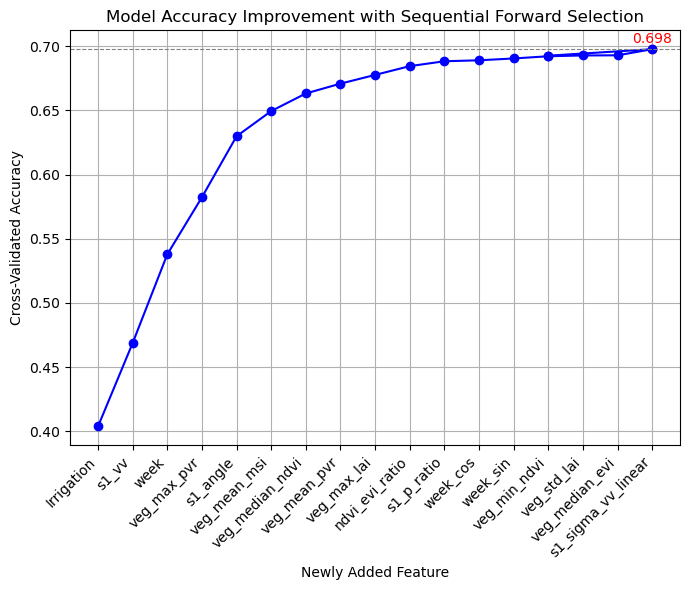

✔️ Feature importance plot saved to: Models_Pictures/SB25rAll_n0.2_process_filt_ffs_accuracy_improvement.png


In [ ]:
plt.figure(figsize=(7, 6))
plt.plot(new_features, accuracies, marker='o', linestyle='-', color='b')

# Highlight max accuracy
max_acc = max(accuracies)
plt.axhline(y=max_acc, color='gray', linestyle='--', linewidth=0.8)

# Mark the elbow point
best_idx = np.argmax(accuracies)
plt.scatter(best_idx, accuracies[best_idx], color='red')
plt.text(best_idx, accuracies[best_idx] + 0.005, f'{accuracies[best_idx]:.3f}', ha='center', color='red')

# Rotate labels
plt.xticks(rotation=45, ha='right')

plt.title('Model Accuracy Improvement with Sequential Forward Selection')
plt.xlabel('Newly Added Feature')
plt.ylabel('Cross-Validated Accuracy')
plt.grid(True)
plt.tight_layout()

# Save plot
fig_path = os.path.join(model_pic_basepath, f"{dataset_name}{reduction_method}_ffs_accuracy_improvement.png")
plt.savefig(fig_path)
plt.show()

print(f"✔️ Feature importance plot saved to: {fig_path}")


## 0.8 Train the Final XGBoost Model

With the best subset of features identified, we now train the **final model**.

- The dataset is split into training and validation sets (80/20 split).  
- Class weights are recalculated for balance.  
- **Early stopping** is used to avoid overfitting.  
- Model performance is tested on an **independent year (2019)** to ensure 
  it generalizes well to unseen data.

Metrics such as precision, recall, F1-score, and overall accuracy 
are computed and saved for reporting.

In [ ]:
df2 = df1[[label_col] + list(selected_columns)].copy()  # 🔸 Add .copy() here
df2.loc[:, "Year"] = df.loc[df2.index, "Year"].values

X2 = df2[selected_columns].values
y = df2[label_col].values.ravel()
predictors2 = df2.columns[1:]


In [ ]:
# 🔹 Define Final Model
xgb2 = XGBClassifier(
    n_estimators=n_estimators,
    learning_rate=learning_rate,
    max_depth=max_depth,
    subsample=subsample,
    colsample_bytree=colsample_bytree,
    random_state=r_s,
    n_jobs=ncpus,
    eval_metric="mlogloss",             # ✅ now correctly placed
    early_stopping_rounds=20            # ✅ now correctly placed
)

# 🔹 Compute Sample Weights for Final Model
sample_weights2 = compute_sample_weight(class_weight="balanced", y=y)

# 🔹 Split into training and validation sets (stratified by class)
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val, sw_train, sw_val = train_test_split(
    X2, y, sample_weights2, test_size=0.2, random_state=1, stratify=y
)

# 🔹 Train the Final Model with Early Stopping
xgb2.fit(
    X_train, y_train,
    sample_weight=sw_train,
    eval_set=[(X_val, y_val)],
    sample_weight_eval_set=[sw_val],
    verbose=True
)

# ✅🧪 Evaluate on True Test Set
test_mask = df1["GroupID"].isin(test_groups)
X_test = df1.loc[test_mask, selected_columns].values
y_test = df1.loc[test_mask, label_col].values.ravel()

from sklearn.metrics import classification_report
y_test_pred = xgb2.predict(X_test)
print("🧪 Evaluation on True Test Set:")
print(classification_report(y_test, y_test_pred, digits=3))


# 🔹 Save classification report to JSON
report = classification_report(y_test, y_test_pred, digits=3, output_dict=True)

report_path = os.path.join(model_pic_basepath, f"{dataset_name}{reduction_method}_true_test_report.json")
with open(report_path, "w") as f:
    json.dump(report, f, indent=2)

print(f"📝 True test report saved to: {report_path}")



[0]	validation_0-mlogloss:2.13491
[1]	validation_0-mlogloss:2.00771
[2]	validation_0-mlogloss:1.90084
[3]	validation_0-mlogloss:1.82080
[4]	validation_0-mlogloss:1.74437
[5]	validation_0-mlogloss:1.68101
[6]	validation_0-mlogloss:1.62581
[7]	validation_0-mlogloss:1.57289
[8]	validation_0-mlogloss:1.52605
[9]	validation_0-mlogloss:1.48391
[10]	validation_0-mlogloss:1.44729
[11]	validation_0-mlogloss:1.41475
[12]	validation_0-mlogloss:1.38372
[13]	validation_0-mlogloss:1.35500
[14]	validation_0-mlogloss:1.33036
[15]	validation_0-mlogloss:1.30576
[16]	validation_0-mlogloss:1.27999
[17]	validation_0-mlogloss:1.25797
[18]	validation_0-mlogloss:1.23951
[19]	validation_0-mlogloss:1.22135
[20]	validation_0-mlogloss:1.20305
[21]	validation_0-mlogloss:1.18629
[22]	validation_0-mlogloss:1.16946
[23]	validation_0-mlogloss:1.15462
[24]	validation_0-mlogloss:1.14220
[25]	validation_0-mlogloss:1.12985
[26]	validation_0-mlogloss:1.11760
[27]	validation_0-mlogloss:1.10630
[28]	validation_0-mlogloss:1.0

In [ ]:
# ✅🧪 Evaluate on True Test Set
test_mask = df1["GroupID"].isin(test_groups)
X_test = df1.loc[test_mask, selected_columns].values
y_test = df1.loc[test_mask, label_col].values.ravel()

from sklearn.metrics import classification_report
y_test_pred = xgb2.predict(X_test)
print("🧪 Evaluation on True Test Set:")
print(classification_report(y_test, y_test_pred, digits=3))

# 🔹 Generate confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_test_pred)
labels = sorted(np.unique(y_test))  # or use your class labels directly

# 🔹 Plot and save confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - True Test Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

cm_image_path = os.path.join(model_pic_basepath, f"{dataset_name}{reduction_method}_confusion_matrix.png")
plt.tight_layout()
plt.savefig(cm_image_path)
plt.close()

print(f"📊 Confusion matrix image saved to: {cm_image_path}")

# 🔹 Optionally save the raw values as CSV
cm_csv_path = os.path.join(model_pic_basepath, f"{dataset_name}{reduction_method}_confusion_matrix.csv")
pd.DataFrame(cm, index=labels, columns=labels).to_csv(cm_csv_path)
print(f"📊 Confusion matrix CSV saved to: {cm_csv_path}")


🧪 Evaluation on True Test Set:
              precision    recall  f1-score   support

         0.0      0.661     0.589     0.623      2560
         1.0      0.710     0.601     0.651      2250
         2.0      0.540     0.813     0.649       850
         3.0      0.980     0.953     0.966      1763
         4.0      0.939     0.986     0.962      3031
         5.0      0.879     0.745     0.806      6294
         6.0      0.749     0.745     0.747      3194
         7.0      0.208     0.882     0.337       289
         8.0      0.462     0.905     0.612        95
         9.0      0.646     0.986     0.781        74

    accuracy                          0.770     20400
   macro avg      0.677     0.821     0.713     20400
weighted avg      0.804     0.770     0.780     20400

📊 Confusion matrix image saved to: Models_Pictures/SB25rAll_n0.2_process_filt_confusion_matrix.png
📊 Confusion matrix CSV saved to: Models_Pictures/SB25rAll_n0.2_process_filt_confusion_matrix.csv


## 0.9 Feature Importance of Final Model

We visualize and save the final **feature importance** chart.

This chart highlights which predictors (e.g., NDVI, week, irrigation, 
Sentinel-1 radar indicators) had the largest impact on the model’s decisions.  
It provides transparency and helps interpret what drives classification results.

In [ ]:
feature_importances_final = pd.DataFrame(
    xgb2.feature_importances_, 
    index=selected_columns, 
    columns=['importance']
).sort_values('importance', ascending=False)

Text(0, 0.5, 'Features')

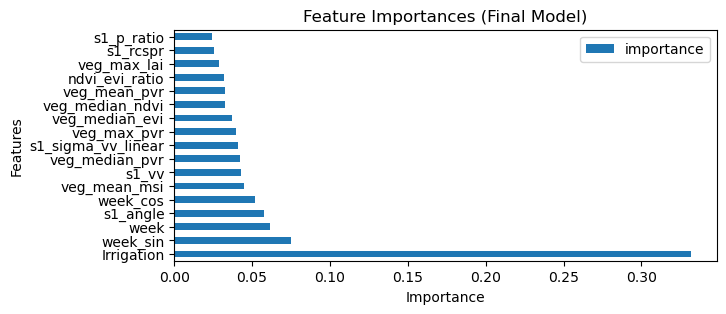

In [ ]:
# Plot and save feature importance
fig, ax = plt.subplots(figsize=(7, 3))
feature_importances_final.plot(kind='barh', ax=ax)
ax.set_title('Feature Importances (Final Model)')
ax.set_xlabel('Importance')
ax.set_ylabel('Features')

## 0.10 Model Evaluation and Confusion Matrices

In this section, we evaluate model performance using **two complementary confusion matrices**.

### 1️⃣ Cross-Validation Confusion Matrix
This matrix is built using **5-fold Group Cross-Validation**:
- The dataset is divided into five parts (folds).
- The model is trained on four folds and tested on the fifth.
- Each fold ensures that all samples from the same field stay together (Group K-Fold).
- The confusion matrix is then created from the combined predictions across all folds.

This view helps assess how consistent the model is across multiple rounds of training and validation.

### 2️⃣ Independent Test-Year Confusion Matrix
Here we test the model on a completely **independent year (2019)** that was not used during training.
- All parcels from 2019 are used purely for validation.
- The matrix shows the number (left panel) and percentage (right panel) of correctly and incorrectly classified fields per crop type.

This matrix is the **most relevant for real-world performance**, since it represents how the model behaves on unseen data from a new season.

### Interpretation
- **Diagonal cells** represent correct classifications.  
- **Off-diagonal cells** show where the model confuses crop types.  
- The color intensity indicates how frequent each prediction is.  
- Accompanying metrics (accuracy, F1-score, precision, recall) summarize overall reliability.

Together, these matrices provide both a broad internal validation (cross-validation)
and a realistic external validation (independent test set).


In [ ]:
# Combine FIELDID and Year to create a unique group identifier
df2 = df2.copy()
df2["GroupID"] = df.loc[df2.index, "FIELDID"].astype(str) + "_" + df.loc[df2.index, "Year"].astype(str)
groups = df2["GroupID"].values

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict

# 🔹 Redefine a new model for cross-validation (no early stopping)
xgb_cv = XGBClassifier(
    n_estimators=n_estimators,
    learning_rate=learning_rate,
    max_depth=max_depth,
    subsample=subsample,
    colsample_bytree=colsample_bytree,
    random_state=r_s,
    n_jobs=ncpus,
    eval_metric="mlogloss"  # optional: keeps evaluation consistent
)

# 🔹 5-fold Stratified CV
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
from sklearn.model_selection import GroupKFold
gkf = GroupKFold(n_splits=5)

overall_acc = cross_val_score(xgb_cv, X2, y, cv=gkf, groups=groups, scoring='accuracy', n_jobs=ncpus)
f1_macro = cross_val_score(xgb_cv, X2, y, cv=gkf, groups=groups, scoring='f1_macro', n_jobs=ncpus)
predictions = cross_val_predict(xgb_cv, X2, y, cv=gkf, groups=groups, n_jobs=ncpus)



In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import os

# 🔹 Explicit Crop_num order and names
class_order = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
crop_name_mapping = {
    0: 'Maize',
    1: 'Soy',
    2: 'Sunflower',
    3: 'Wheat',
    4: 'Lucern',
    5: 'Pasture',
    6: 'Tree',
    7: 'Fallow',
    8: 'Groundnuts',
    9: 'Sorghum'
}
class_names_ordered = [crop_name_mapping[i] for i in class_order]


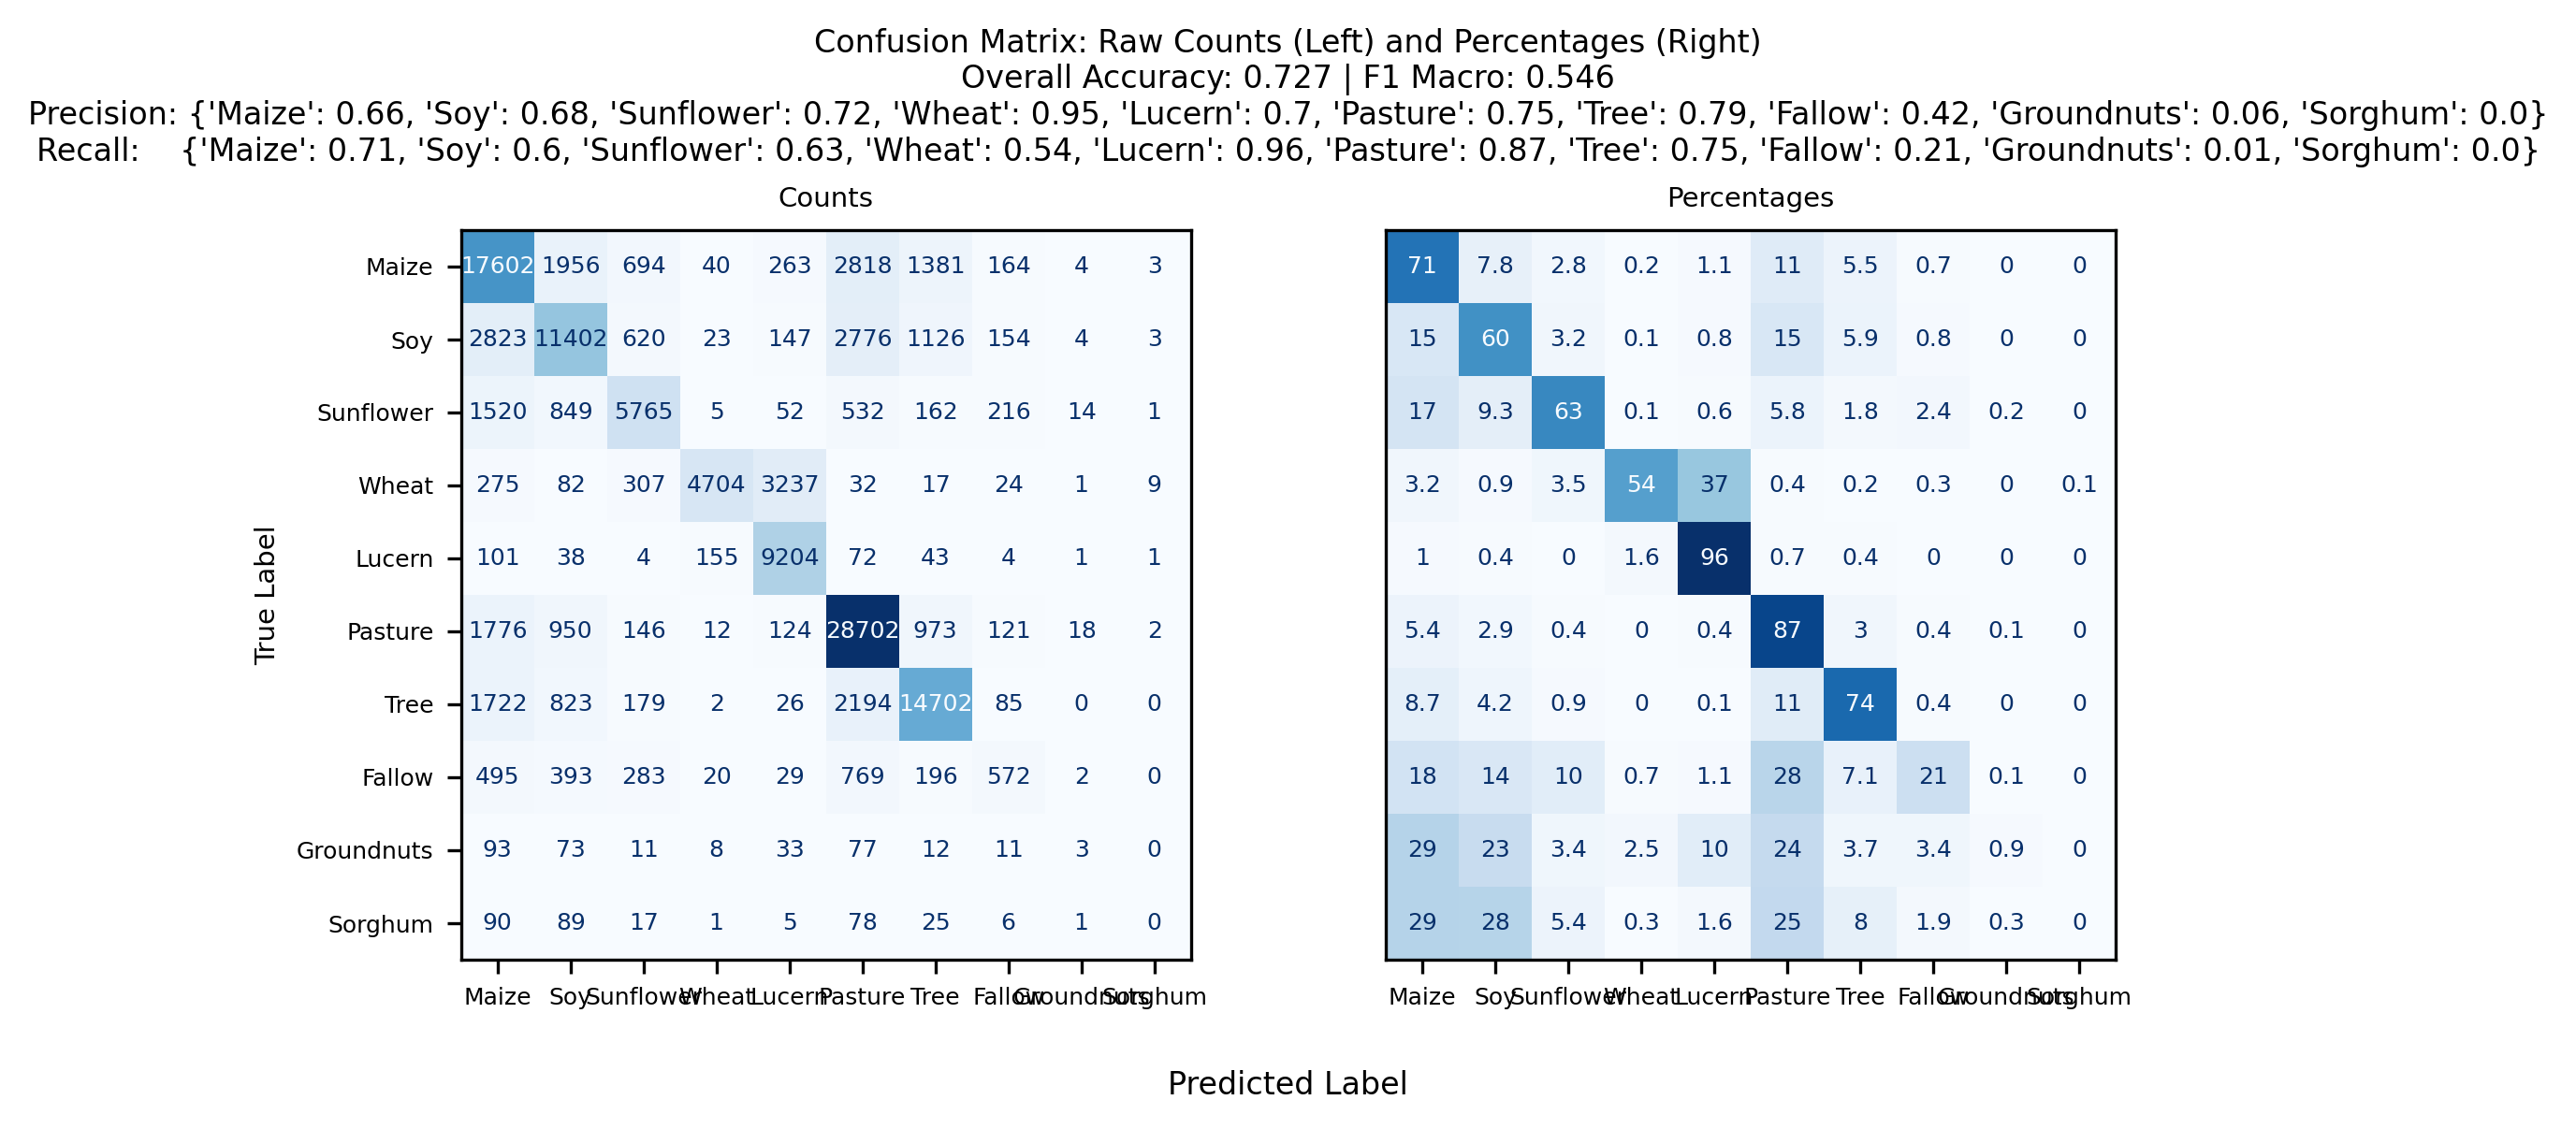

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np
import os

# 🔹 Normalize confusion matrix
conf_matrix = confusion_matrix(y, predictions)
cm_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100
cm_normalized = np.around(cm_normalized, decimals=1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
ax1.set_aspect(1.0 / ax1.get_data_ratio() * 0.8)
ax2.set_aspect(1.0 / ax2.get_data_ratio() * 0.8)

# 🔹 Raw counts
disp1 = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix,
    display_labels=[crop_name_mapping[label] for label in np.unique(y)]
)
disp1.plot(ax=ax1, cmap='Blues', colorbar=False)
ax1.set_title('Counts', fontsize=7)
ax1.set_ylabel('True Label', fontsize=7)
ax1.set_xlabel('')
ax1.tick_params(axis='x', labelsize=6)
ax1.tick_params(axis='y', labelsize=6)
for text in ax1.texts:
    text.set_fontsize(6)

# 🔹 Percentages
disp2 = ConfusionMatrixDisplay(
    confusion_matrix=cm_normalized,
    display_labels=[crop_name_mapping[label] for label in np.unique(y)]
)
disp2.plot(ax=ax2, cmap='Blues', colorbar=False)
ax2.set_title('Percentages', fontsize=7)
ax2.set_ylabel('')
ax2.set_xlabel('')
ax2.tick_params(axis='x', labelsize=6)
ax2.tick_params(axis='y', which='both', left=False, labelleft=False)
for text in ax2.texts:
    text.set_fontsize(6)

plt.subplots_adjust(left=0.1, right=0.9, top=0.8, bottom=0.15, wspace=-0.3)
fig.text(0.5, 0.03, 'Predicted Label', ha='center', fontsize=8)

# 🔹 INSERT THIS BLOCK HERE (before fig.suptitle)
precision = precision_score(y, predictions, average=None)
recall = recall_score(y, predictions, average=None)

fig.suptitle(
    'Confusion Matrix: Raw Counts (Left) and Percentages (Right)\n'
    f'Overall Accuracy: {np.mean(overall_acc):.3f} | '
    f'F1 Macro: {np.mean(f1_macro):.3f}\n'
    f'Precision: {dict(zip([crop_name_mapping[label] for label in np.unique(y)], np.around(precision, 2)))}\n'
    f'Recall:    {dict(zip([crop_name_mapping[label] for label in np.unique(y)], np.around(recall, 2)))}',
    fontsize=8
)

# 🔹 Save and display
confmat_path = os.path.join(model_pic_basepath, f'{dataset_name}{reduction_method}_matrix.png')
plt.savefig(confmat_path, dpi=300, bbox_inches="tight")
plt.close()

from IPython.display import Image, display
display(Image(filename=confmat_path))


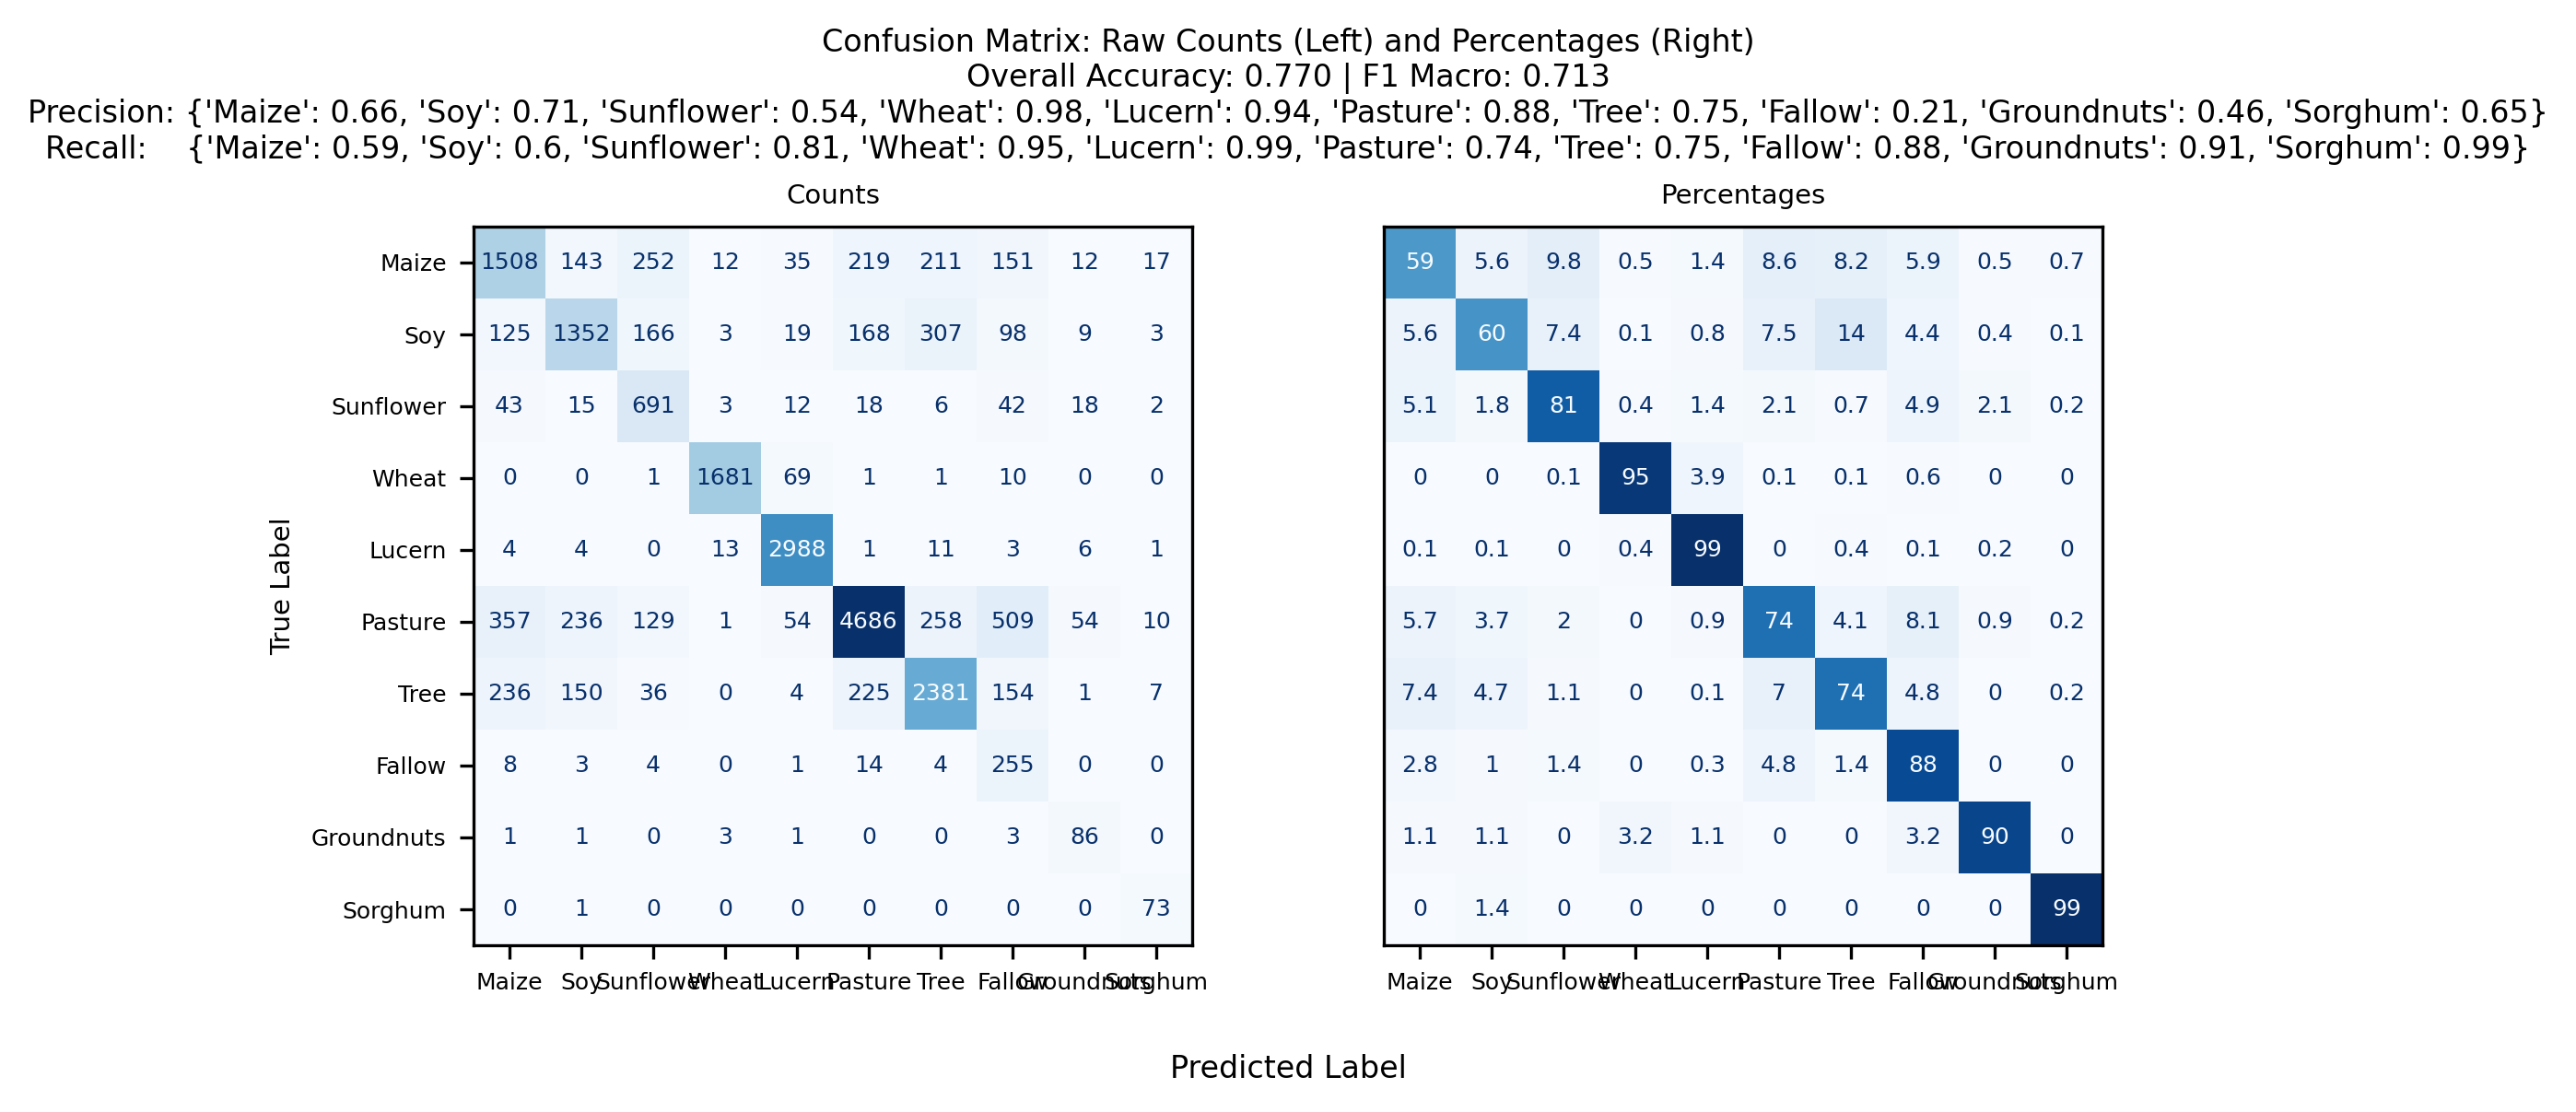

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from IPython.display import Image, display

# 🔹 Ensure you're predicting on the true test set
y_test_pred = xgb2.predict(X_test)

# 🔹 Confusion matrix and normalized version
conf_matrix = confusion_matrix(y_test, y_test_pred)
cm_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100
cm_normalized = np.around(cm_normalized, decimals=1)

# 🔹 Class label mapping
labels = np.unique(y_test)
label_names = [crop_name_mapping[label] for label in labels]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
ax1.set_aspect(1.0 / ax1.get_data_ratio() * 0.8)
ax2.set_aspect(1.0 / ax2.get_data_ratio() * 0.8)

# 🔹 Raw counts
disp1 = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_names)
disp1.plot(ax=ax1, cmap='Blues', colorbar=False)
ax1.set_title('Counts', fontsize=7)
ax1.set_ylabel('True Label', fontsize=7)
ax1.set_xlabel('')
ax1.tick_params(axis='x', labelsize=6)
ax1.tick_params(axis='y', labelsize=6)
for text in ax1.texts:
    text.set_fontsize(6)

# 🔹 Percentages
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=label_names)
disp2.plot(ax=ax2, cmap='Blues', colorbar=False)
ax2.set_title('Percentages', fontsize=7)
ax2.set_ylabel('')
ax2.set_xlabel('')
ax2.tick_params(axis='x', labelsize=6)
ax2.tick_params(axis='y', which='both', left=False, labelleft=False)
for text in ax2.texts:
    text.set_fontsize(6)

plt.subplots_adjust(left=0.1, right=0.9, top=0.8, bottom=0.15, wspace=-0.3)
fig.text(0.5, 0.03, 'Predicted Label', ha='center', fontsize=8)

# 🔹 Precision and Recall (test set only)
precision = precision_score(y_test, y_test_pred, average=None)
recall = recall_score(y_test, y_test_pred, average=None)
overall_acc = np.mean(y_test_pred == y_test)
from sklearn.metrics import f1_score
f1_macro = f1_score(y_test, y_test_pred, average='macro')

fig.suptitle(
    'Confusion Matrix: Raw Counts (Left) and Percentages (Right)\n'
    f'Overall Accuracy: {overall_acc:.3f} | '
    f'F1 Macro: {f1_macro:.3f}\n'
    f'Precision: {dict(zip(label_names, np.around(precision, 2)))}\n'
    f'Recall:    {dict(zip(label_names, np.around(recall, 2)))}',
    fontsize=8
)

# 🔹 Save and display
confmat_path = os.path.join(model_pic_basepath, f'{dataset_name}{reduction_method}_test_matrix.png')
plt.savefig(confmat_path, dpi=300, bbox_inches="tight")
plt.close()
display(Image(filename=confmat_path))

## 0.11 Save the Final Model and Features

Finally, we export all essential outputs so the model can be reused later without retraining:

- The **trained model file** (`.joblib`)  
- The **list of selected features** (`.json`)  
- Evaluation results and confusion matrices (`.json`, `.csv`, `.png`)  
- A summary file with accuracy and feature details  

These outputs ensure transparency, reproducibility, and easy deployment for future predictions.


In [ ]:
# Save model and features
model_path = os.path.join(model_basepath, f'{dataset_name}{reduction_method}_xgb{n_estimators}_nf{top_N}_noMet_v1.joblib')
dump(xgb2, model_path)

['Models/SB25rAll_n0.2_process_filt_xgb200_nf25_noMet_v1.joblib']

In [ ]:
features_path = os.path.join(model_basepath, f'{dataset_name}{reduction_method}_xgb{n_estimators}_nf{top_N}_noMet_v1.json')
with open(features_path, "w", encoding="utf-8") as f:
    json.dump({"features": list(selected_columns)}, f, ensure_ascii=False, indent=4)

In [ ]:
from sklearn.metrics import f1_score

# ➤ Evaluate on full dataset
X_full = df1[selected_columns].values
y_full = df1[label_col].values.ravel()
preds_final = xgb2.predict(X_full)

accuracy = accuracy_score(y_full, preds_final)
f1_weighted = f1_score(y_full, preds_final, average='weighted')

print(f"✔️ Final accuracy: {accuracy:.4f}")
print(f"✔️ Weighted F1 score: {f1_weighted:.4f}")

# ✅ Save evaluation summary with all relevant metadata
summary = {
    "Final_Accuracy": round(accuracy, 4),
    "Weighted_F1": round(f1_weighted, 4),
    "Selected_Features": list(selected_columns),
    "Num_Selected_Features": len(selected_columns),
    "Model_File": model_path,
    "Features_File": features_path,
    "True_Test_Report_File": report_path,
    "Confusion_Matrix_Image": cm_image_path,
    "Confusion_Matrix_CSV": cm_csv_path
}

summary_file = os.path.join(model_pic_basepath, f"{dataset_name}{reduction_method}_evaluation_summary.json")
with open(summary_file, "w") as f:
    json.dump(summary, f, indent=2)

print(f"✔️ Evaluation summary saved to {summary_file}")



✔️ Final accuracy: 0.7784
✔️ Weighted F1 score: 0.7834
✔️ Evaluation summary saved to Models_Pictures/SB25rAll_n0.2_process_filt_evaluation_summary.json


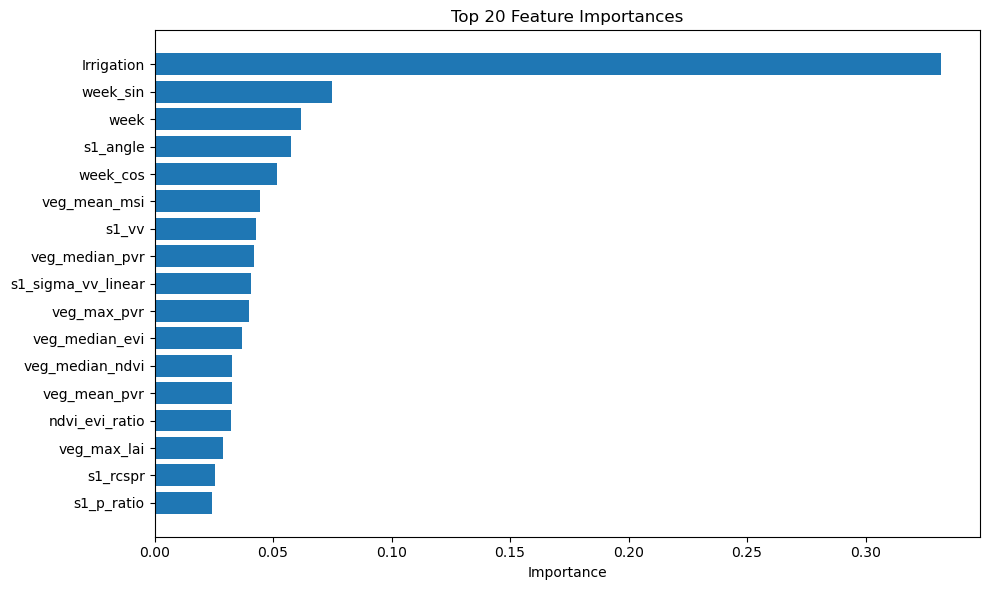

✔️ Feature importance plot saved to: Models_Pictures/SB25rAll_n0.2_process_filt_feature_importance.png


In [ ]:
# ➤ Feature Importance Plot
import matplotlib.pyplot as plt
import pandas as pd

# Get feature importances from trained model
importances = xgb2.feature_importances_
feature_names = selected_columns  # FFS-selected features

# Build a DataFrame for sorting
imp_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Plot top 20 features
top_k = 20
plt.figure(figsize=(10, 6))
plt.barh(imp_df["Feature"].head(top_k)[::-1], imp_df["Importance"].head(top_k)[::-1])
plt.xlabel("Importance")
plt.title("Top 20 Feature Importances")
plt.tight_layout()

# Save plot
fig_path = os.path.join(model_pic_basepath, f"{dataset_name}{reduction_method}_feature_importance.png")
plt.savefig(fig_path)
plt.show()

print(f"✔️ Feature importance plot saved to: {fig_path}")


### Understanding the Evaluation Metrics

These four values help us understand how well the model performs for each crop type.

- **Precision →** How often the model’s predictions are right.  
  *(Example: If the model predicts 100 fields as Wheat and 90 are actually Wheat, precision = 0.90.)*

- **Recall →** How many of the real cases the model actually finds.  
  *(Example: If there are 100 real Wheat fields and the model correctly identifies 90 of them, recall = 0.90.)*

- **F1-score →** The balance between precision and recall.  
  *(It is high only when the model is both accurate and complete — meaning it predicts correctly and finds most of the real cases.)*

- **Support →** The number of samples (fields) that belong to each crop type in the dataset.  
  *(It helps you see which crops are common and which ones are rare.)*

**In short:**  
- High **precision** → few wrong predictions.  
- High **recall** → few missed fields.  
- High **F1-score** → good balance between both.  
- **Support** → how many fields were used to measure that score.



In [ ]:
from sklearn.metrics import classification_report

# ➤ Define readable class labels
crop_name_mapping = {
    0: 'Maize',
    1: 'Soy',
    2: 'Sunflower',
    3: 'Wheat',
    4: 'Lucern',
    5: 'Pasture',
    6: 'Tree',
    7: 'Fallow',
    8: 'Groundnuts',
    9: 'Sorghum'
}
target_names = [crop_name_mapping[i] for i in sorted(crop_name_mapping.keys())]

# ➤ Print detailed per-class metrics for test set
print("\n🔍 Per-class performance metrics (True Test Set Only):")
print(classification_report(y_test, y_test_pred, target_names=target_names, digits=3))

# ➤ Optional: Save report to file
report = classification_report(y_test, y_test_pred, target_names=target_names, digits=3)
report_path = os.path.join(model_pic_basepath, f"{dataset_name}{reduction_method}_testset_classification_report.txt")
with open(report_path, "w") as f:
    f.write(report)

print(f"📄 Test set per-class report saved to: {report_path}")



🔍 Per-class performance metrics (True Test Set Only):
              precision    recall  f1-score   support

       Maize      0.661     0.589     0.623      2560
         Soy      0.710     0.601     0.651      2250
   Sunflower      0.540     0.813     0.649       850
       Wheat      0.980     0.953     0.966      1763
      Lucern      0.939     0.986     0.962      3031
     Pasture      0.879     0.745     0.806      6294
        Tree      0.749     0.745     0.747      3194
      Fallow      0.208     0.882     0.337       289
  Groundnuts      0.462     0.905     0.612        95
     Sorghum      0.646     0.986     0.781        74

    accuracy                          0.770     20400
   macro avg      0.677     0.821     0.713     20400
weighted avg      0.804     0.770     0.780     20400

📄 Test set per-class report saved to: Models_Pictures/SB25rAll_n0.2_process_filt_testset_classification_report.txt
